This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

Update the John Holkins, Covid-19 data https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [8]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [9]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'USA',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (1,1,0), # I initially tried p,d,q of 7,2,0 based on the ACF and PACF. It did not converge.
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '12-31-2020'}

The "data date" is 2020-06-01 00:00:00

ADF Statistic: -1.723353
p-value: 0.419122
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586


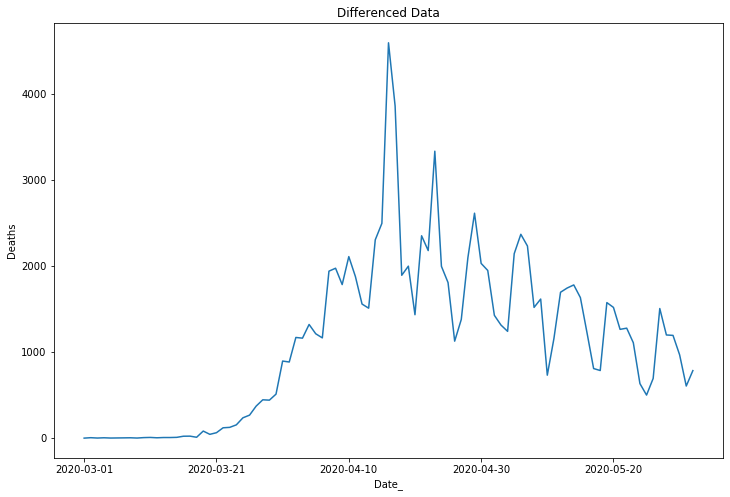

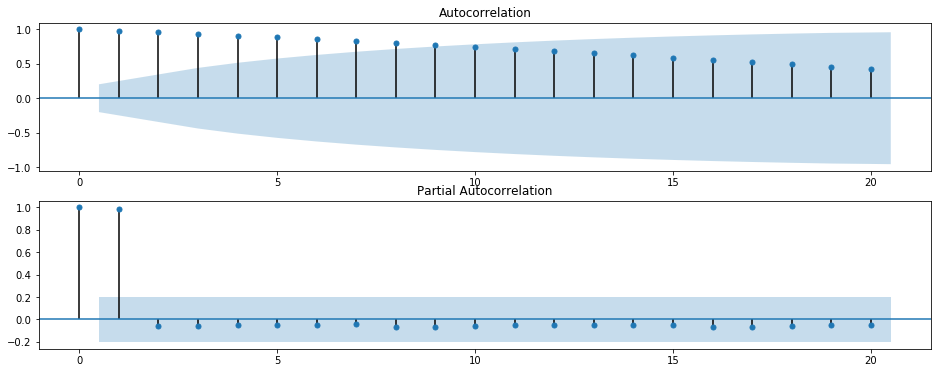

ARIMA(0, 0, 1) RMSE=39124.604
ARIMA(0, 1, 1) RMSE=1223.879
ARIMA(0, 2, 1) RMSE=668.735
ARIMA(0, 2, 2) RMSE=752.185
ARIMA(1, 0, 0) RMSE=1825.450
ARIMA(1, 1, 0) RMSE=647.749
ARIMA(1, 2, 0) RMSE=679.087
ARIMA(1, 2, 1) RMSE=697.660
ARIMA(2, 1, 0) RMSE=675.328
ARIMA(2, 2, 0) RMSE=810.224
Best ARIMA(1, 1, 0) RMSE=647.749
RMSE: 647.749
                 0
count    47.000000
mean     53.455270
std     652.518647
min   -1910.415504
25%    -306.625689
50%      14.097912
75%     281.321453
max    2117.744661


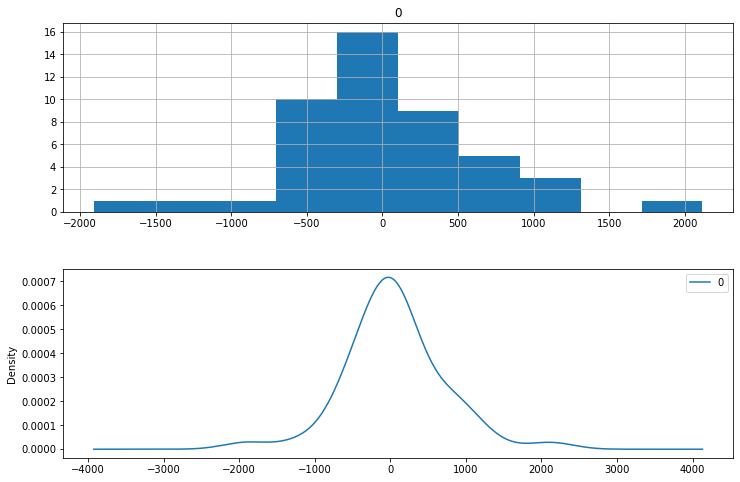


bias IS saved in arg_dict["bias"] for subsequent run is: 53.45527021078956 

RMSE: 645.540
                  0
count  4.700000e+01
mean  -7.740380e-13
std    6.525186e+02
min   -1.963871e+03
25%   -3.600810e+02
50%   -3.935736e+01
75%    2.278662e+02
max    2.064289e+03


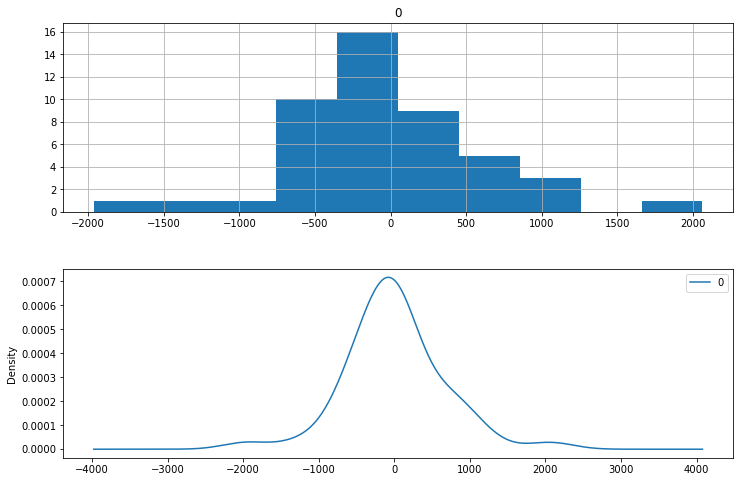


bias NOT saved in arg_dict["bias"] for subsequent run is: -7.740380440620666e-13 



In [10]:
# Load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


The predicted cumulative Deaths for USA for tomorrow (input data plus 1 day) are 105,001


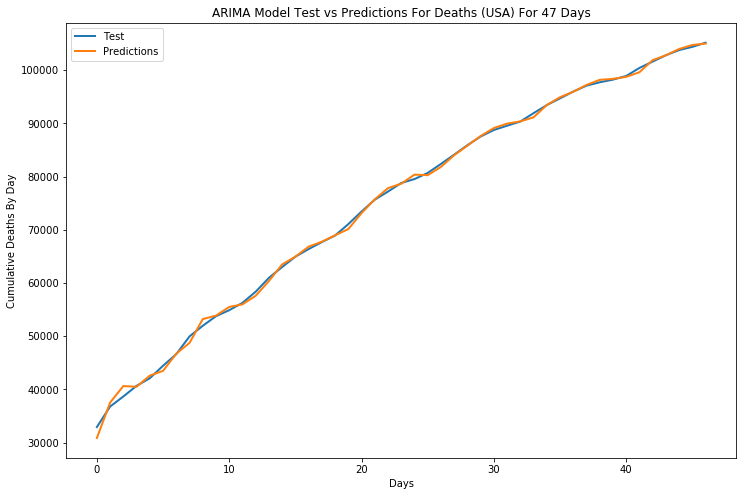

In [11]:
# Plot test (actual) vs predictions, save, and forecast
tpsf1.driver(arg_dict)

NB The above prediction of a single day in the future will only rarely match the the first day in the multi step forecast below. The reason is that the ARIMA model is a moving average model. The specific days included in the moving average change in the multi step forecast. 

The USA prediction is for 325,707 cumulative Deaths to occur by 2020-12-31 00:00:00


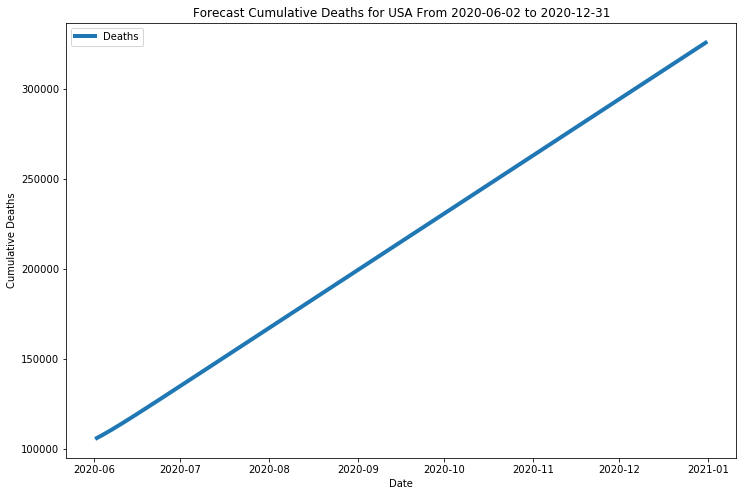

In [12]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to have no more instances by the date indicated. We truncate the prediction at that point. 

In [13]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.tail() 

Actual


,Deaths,Daily_Deaths
Date_,,
2020-05-28,101616.0,1198.0
2020-05-29,102809.0,1193.0
2020-05-30,103776.0,967.0
2020-05-31,104381.0,605.0
2020-06-01,105165.0,784.0


In [14]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head()

Predicted


,Deaths,Daily_Deaths
Date_,,
2020-06-02,106038.0,873.0
2020-06-03,106888.0,850.0
2020-06-04,107764.0,876.0
2020-06-05,108664.0,900.0
2020-06-06,109583.0,919.0
